In [1]:
import os
from pathlib import Path
BASEDIR = Path(os.getcwd()).parent
MODELDIR = BASEDIR / "models"

In [2]:
import numpy as np
from datasets import load_dataset, load_metric, Features, ClassLabel, Array3D
from transformers import ViTForImageClassification, ViTFeatureExtractor

from tqdm import tqdm
import seaborn as sns

D:\Programming\fourthbrain\cifar\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = load_dataset('cifar100')
splits = data['train'].train_test_split(test_size=0.3)
train_ds = splits['train'].select(range(2000))
val_ds = splits['test'].select(range(1000))

Reusing dataset cifar100 (C:\Users\bne\.cache\huggingface\datasets\cifar100\cifar100\1.0.0\f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142)
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 68.97it/s]


In [4]:
labelk = 'coarse_label'
id2label = {id:label for id, label in enumerate(train_ds.features[labelk].names)}
label2id = {label:id for id,label in id2label.items()}

In [5]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

In [6]:
model = ViTForImageClassification.from_pretrained(MODELDIR / 'model0', local_files_only=True)

In [7]:
def predict_by_index(ix=1234):
    feature = feature_extractor(train_ds[ix]['img'], return_tensors='pt')
    preds = model(**feature).logits
    best = preds.argmax(-1).item()
    
    return id2label[best], id2label[train_ds[ix]['coarse_label']]
predict_by_index()

('reptiles', 'reptiles')

In [8]:
conf_mat = np.zeros((20,20))
for img in tqdm(val_ds):
    feature = feature_extractor(img['img'], return_tensors='pt')
    pred = model(**feature).logits.argmax(-1).item()
    conf_mat[img['coarse_label']][pred] += 1

100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:01<00:00,  1.14s/it]


<AxesSubplot:>

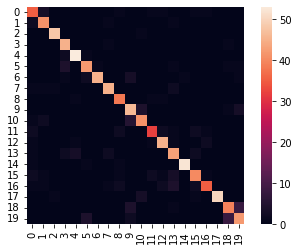

In [9]:
sns.heatmap(conf_mat, square=True)

<AxesSubplot:>

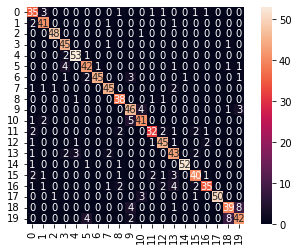

In [10]:
sns.heatmap(conf_mat, annot=True, square=True)

In [11]:
id2label

{0: 'aquatic_mammals',
 1: 'fish',
 2: 'flowers',
 3: 'food_containers',
 4: 'fruit_and_vegetables',
 5: 'household_electrical_devices',
 6: 'household_furniture',
 7: 'insects',
 8: 'large_carnivores',
 9: 'large_man-made_outdoor_things',
 10: 'large_natural_outdoor_scenes',
 11: 'large_omnivores_and_herbivores',
 12: 'medium_mammals',
 13: 'non-insect_invertebrates',
 14: 'people',
 15: 'reptiles',
 16: 'small_mammals',
 17: 'trees',
 18: 'vehicles_1',
 19: 'vehicles_2'}

Pretty good performance across all labels.  The worst seeming to be vehicles_1 vs vehicles_2
May have to get more creative with changing label mappings than expected in order to have a chance at significant differences